In [101]:
#Autores: Daniel Castillo, Karla Salas
from os import listdir
from os.path import isfile, join
#Para ver las palabras
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize #Tokens
import re #regex

[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
         with open(path+"/"+file, 'rb') as f:
            text.append(f.read().decode('utf-8', 'replace'))
    return text

# Guardamos cada película en un diccionario
# cada entrada del diccionario es una lista con las peliculas leídas
movies = {}
movies["Pride & Prejudice"] = get_txt("../corpus/Pride & Prejudice")
movies["Marvel"] = get_txt("../corpus/Marvel")
movies["Christopher Nolan"] = get_txt("../corpus/Christopher Nolan")

In [103]:
def show_words(word):
    '''
    Usa la librería wordcloud para mostrar una gráfica
    de las palabras más usadasen un corpus

    Args:
        word (str): lista de palabras
    '''
    mycloud = WordCloud()
    mycloud.generate_from_frequencies(Counter(word))

    plt.figure(figsize=(8,6), dpi=120)
    plt.imshow(mycloud)
    plt.axis("off")
    plt.show()

In [104]:
def get_tokens(name):
    '''
    Separa los textos de cada película en una entrada
    del diccionario movies, usando la función word_tokenize
    
    Args:
        name (str): nombre de la carpeta de películas
    '''
    corpus = []
    for i, movie in enumerate(movies[name]):
        movies[name][i] = word_tokenize(movie)
        corpus += movies[name][i]
    return corpus

# Mezclamos los corpus de cada película según su autor
marvel = get_tokens("Marvel")
nolan = get_tokens("Christopher Nolan")
pride = get_tokens("Pride & Prejudice")

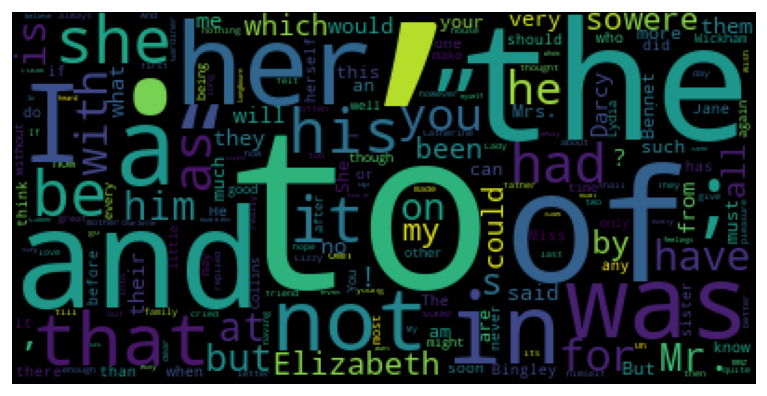

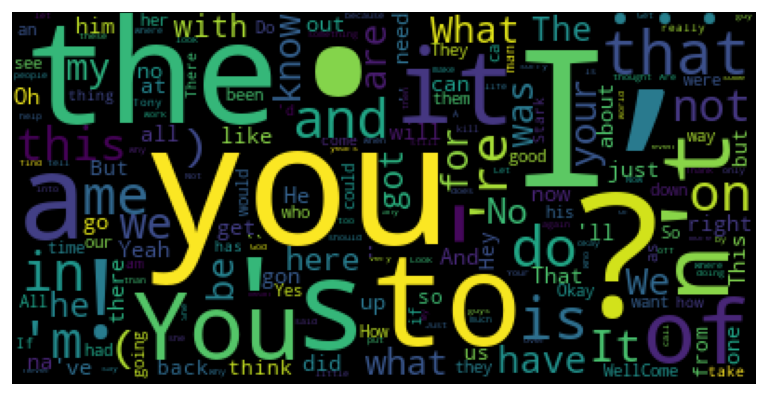

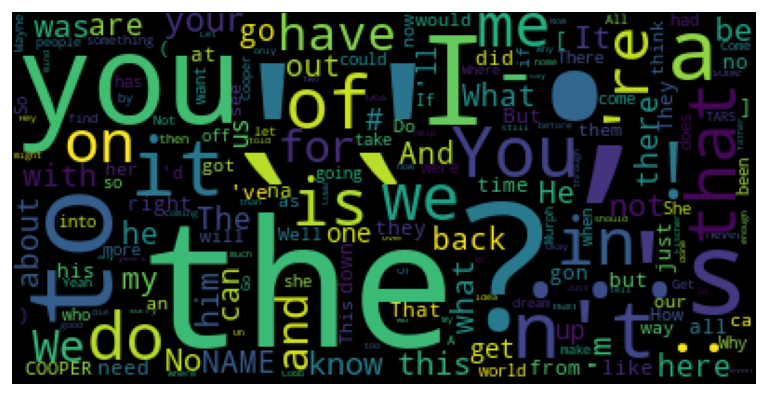

In [105]:
#Gráfica de palabras para la peli (texto sucio)
show_words(pride)
show_words(marvel)
show_words(nolan)

In [106]:
num = len(pride) + len(marvel) + len(nolan)
print("Número de tokens antes de limpiar el texto: ", num)
num = len(set(pride + marvel + nolan))
print("Número de tokens no repetidos (tipos): ", num)

Número de tokens antes de limpiar el texto:  500473
Número de tokens no repetidos (tipos):  20406


In [107]:
# tokens que necesitan ser limpiados del corpus y que no
# se encuentran en la lista de stopwords
more = ["_","-","'ve", "'ll", "'t", "'s", "'re", "'", "'m", "'d", "n't", "oh", "hey", "yeah","okay", "mr.", "miss", "mrs."]
stopwords_list = stopwords.words('english') + more

def clean_corpus(corpus):
    '''
    Limpia el corpus recibido de stopwords
    Args:
        corpus(list): lista de palabras
    '''
    clean = []
    pattern = r'[^a-z0-9\s]'
    for w in corpus:
        #quita stopwords y convierte a minúsculas
        w = w.lower()
        if w not in stopwords_list and re.sub(pattern,'', w) != '':
            if  w == "na": #Para juntar gon na, wan na, etc.
                clean[-1] += w
            else:
                clean.append(w)
    return clean

# Limpiamos los corpus de cada película
movies["Pride & Prejudice"] = clean_corpus(movies["Pride & Prejudice"][0])
movies["Marvel"] = [clean_corpus(m) for m in movies["Marvel"]]
movies["Christopher Nolan"] = [clean_corpus(m) for m in movies["Christopher Nolan"]]

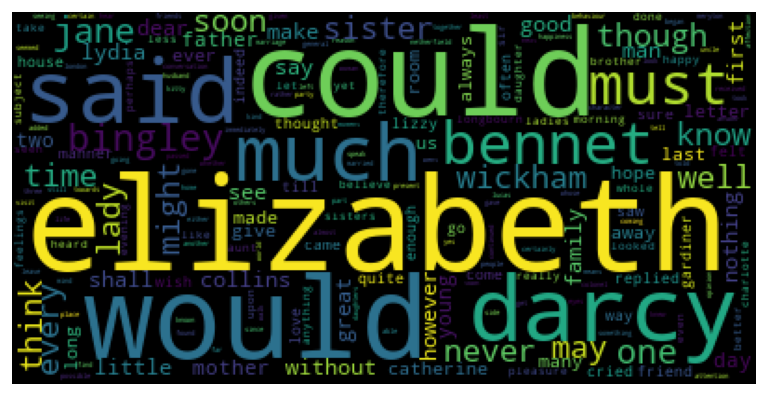

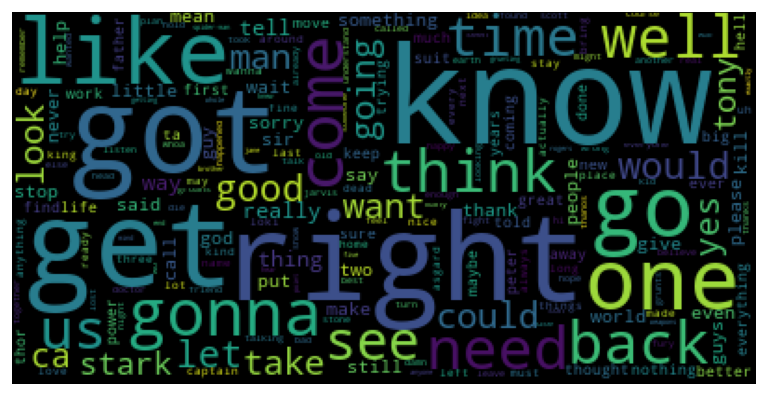

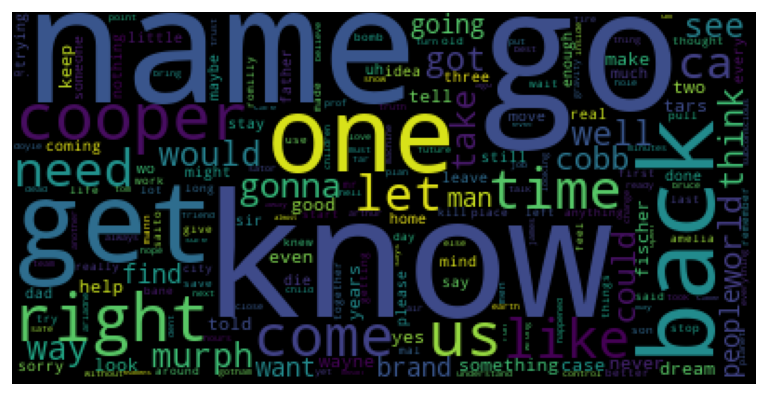

In [108]:
def merge_movies(name):
    '''
    Mezcla el corpus de cada película en una entrada del
    diccionario movies en un solo corpus

    Args:
        name (str): nombre de la carpeta de películas
    '''
    corpus = []
    for movie in movies[name]:
        corpus += movie
    return corpus

# Mostramos la gráfica de palabras de los corpus limpios
show_words(movies["Pride & Prejudice"])
show_words(merge_movies("Marvel"))
show_words(merge_movies("Christopher Nolan"))

# Algoritmo BPE

In [122]:
def get_dic(corpus):
    '''
    Obtiene el diccionario del corpus dado
    en formato palabra -> frecuencia

    Args:
        corpus (str): lista de palabras
    '''
    # agregamos espacios a cada token
    corpus = [' '.join(token) for token in corpus]

    # Creamos el diccionario
    return Counter(corpus)

dic_prejudice = get_dic(movies['Pride & Prejudice'])
dic_marvel = get_dic(merge_movies('Marvel'))
dic_nolan = get_dic(merge_movies('Christopher Nolan'))

In [119]:
def get_pairs(sigma):
    '''
    Obtiene los pares y su frecuencia dentro del diccionario
    '''
    pairs = {}
    for word, freq in sigma.items():
        chars = word.split()
        for i in range(len(chars)-1):
            # par!
            aux = (chars[i], chars[1+i])
            pairs[aux] = freq if aux not in pairs else pairs[aux] + freq

    return pairs


def merge_frequent(pair, dic):
    '''
    Sustituye el par recibido dentro del diccionario
    '''

    new_dic = {}
    for word in dic:
        #(a, b) -> 'ab'
        new_word = word.replace(' '.join(pair), ''.join(pair))
        # define un nuevo diccionario con el nuevo simbolo ab
        new_dic[new_word] = dic[word]
    
    return new_dic
        

def BPE(epoch, dic):
    '''
    Algoritmo BPE

    Args:
        epoch (int): número de iteraciones que va a correr el algoritmo
        dic (Counter): el diccionario parabra -> frecuencia
    '''
    new_dic = dic
    for _ in range(epoch):
        # Obtenemos los pares y sus frecuencias
        pairs = get_pairs(new_dic)
        try:
            #Símbolo de mayor frecuencia
            best = max(pairs, key=pairs.get)
            # sustituimos 'a b' por 'ab' en el dicionario
            new_dic = merge_frequent(best, new_dic)
        except:
            break
    return new_dic

In [124]:
# Pruebas
dic_prejudice = BPE(200, dic_prejudice)
dic_prejudice

{'1': 1,
 'truth': 27,
 'uni ver s ally': 3,
 'acknow led ged': 20,
 'sing le': 11,
 'man': 144,
 'po ssession': 9,
 'good': 180,
 'fort une': 36,
 'must': 304,
 'w ant': 43,
 'wi fe': 45,
 'however': 133,
 'little': 184,
 'know n': 57,
 'feelings': 85,
 'vi e w s': 11,
 'may': 189,
 'first': 144,
 'entering': 9,
 'ne i gh bour hood': 26,
 'well': 205,
 'fi x ed': 22,
 'mind s': 4,
 'sur roun ding': 2,
 'fami li es': 5,
 'consi dered': 23,
 'ri ght ful': 1,
 'pro per t y': 7,
 'one': 263,
 'daughter s': 50,
 'dear': 157,
 'bennet': 320,
 'said': 401,
 'lady': 190,
 'day': 129,
 'heard': 84,
 'nether field': 72,
 'par k': 22,
 'let': 75,
 'last': 117,
 'replied': 103,
 'retur ned': 45,
 'long': 111,
 'to ld': 68,
 'it .': 28,
 'made': 125,
 'ans wer': 62,
 'know': 232,
 'taken': 31,
 'cried': 91,
 'im p ati ent ly': 5,
 '_ y ou _': 29,
 'tell': 71,
 'ob jection': 15,
 'hearing': 23,
 'in vit ation': 34,
 'enough': 103,
 'say s': 14,
 'young': 130,
 'l ar ge': 22,
 'nor th': 6,
 'eng l a

In [126]:
dic_marvel = BPE(250, dic_marvel)
dic_marvel

{'asgardi an': 14,
 're f u ge e': 2,
 'vessel': 7,
 'states man': 1,
 'assa ult': 7,
 'repe at': 15,
 'en gines': 10,
 'dead': 119,
 'life': 185,
 'suppor t': 15,
 'fa iling': 5,
 're questing': 5,
 'a id': 6,
 'within': 30,
 'ran ge': 7,
 '2 2': 5,
 'j um p': 17,
 'points': 8,
 'asgard': 122,
 'cre w': 8,
 'made': 139,
 'famili es': 8,
 'soldier s': 21,
 'war cra ft': 2,
 'hear': 84,
 're jo ice': 4,
 'pri vile ge': 5,
 'saved': 48,
 'great': 184,
 'titan': 7,
 'may': 115,
 'think': 521,
 'su ffering': 5,
 'sal vati on': 5,
 'uni ver sal': 5,
 's cales': 2,
 'ti p': 5,
 'toward': 6,
 'balan ce': 7,
 'sac ri fice': 6,
 's mile': 7,
 'even': 232,
 'death': 71,
 'be come': 36,
 'children': 24,
 'thanos': 94,
 'know': 1237,
 'like': 858,
 'lose': 66,
 'feel': 98,
 'desperately': 1,
 'right': 978,
 'yet': 78,
 'fa il': 12,
 'nonetheless': 1,
 'frightening': 2,
 'turn s': 10,
 'le g s': 4,
 'jelly': 2,
 'ask': 80,
 'end': 86,
 'dread': 3,
 'run': 78,
 'destin y': 7,
 'ar ri ves': 2,
 'say'

In [127]:
dic_nolan = BPE(200, dic_nolan)
dic_nolan

{'children': 23,
 'l a u ghing': 3,
 'phil li pa': 15,
 's c re am s': 4,
 's pe a king': 6,
 'j apanese': 2,
 'at tend ant': 4,
 'kil l': 35,
 'know': 264,
 'seen': 19,
 'one': 212,
 'many': 20,
 'years': 65,
 'a go': 26,
 'belon ged': 2,
 'man': 85,
 'met': 12,
 'h al f - re me m bered': 2,
 'dream': 65,
 'po s ses sed': 2,
 'radi cal': 1,
 'no ti ons': 1,
 'cobb': 89,
 'resili en t': 4,
 'parasite': 1,
 'b acteri a': 1,
 'vir us': 2,
 'in testinal': 1,
 'wor m': 2,
 'ar th ur': 26,
 'uh': 49,
 'try ing': 41,
 'say': 49,
 'ide a': 45,
 'hi gh ly': 3,
 'con ta gi ous': 2,
 'taken': 4,
 'hold': 20,
 'b ra in': 9,
 'al mo st': 21,
 'im po ssi ble': 12,
 'eradi cate': 1,
 'ful ly': 4,
 'for med': 1,
 'under sto od': 11,
 'sti ck s': 2,
 'right': 196,
 'some w here': 5,
 'some one': 45,
 'like': 143,
 'ste al': 10,
 'yes': 53,
 'state': 4,
 'cons ci ous': 2,
 'de fen ses': 2,
 'lowered': 1,
 'makes': 10,
 'thou ghts': 2,
 'v ul nera ble': 2,
 'the ft': 1,
 'cal led': 9,
 'ex tracti on': 2